# PerStruc-Denoiser

In [1]:
# Jupyter-notebook magic

# For the matplotlib 
%matplotlib inline
# For reload functions explicitly
%load_ext autoreload
%autoreload 2

In [2]:
# Imports

## Add the modules to the system path
import os
import sys
sys.path.append(os.path.join(".."))

## Libs
import glob
import tifffile
import matplotlib.pyplot as plt
import numpy as np

## Own modules
from perstruc_denoiser import perstruc_denoiser
import utils

C:\Users\PrevedelGroup\.conda\envs\Deep3P_Denoising\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Folder Structures

In [3]:
# Enter the store path for the results and denoised file (with periodic structured noise) here #
path_results = os.path.join("..", "results_PerStruc-Denoiser")
path_dataset = os.path.join("..", "data", "PerStruc-Denoiser")
#********************************************************#

In [4]:
# Create a folder for the PerStruc-Denoiser results folder

# Make a folder to store the PerStruc-Denoiser
os.makedirs(path_results, exist_ok=True)

## Load data

In [5]:
## Load image stack 
filenames_raw = glob.glob(os.path.join(path_dataset, "*-raw.tif"))
filenames_denoised = glob.glob(os.path.join(path_dataset, "*-denoised.tif"))
print("Following denoised file will be PerStruc-denoised:  ", filenames_denoised[0])

file_raw = tifffile.imread(filenames_raw[0])
file_denoised = tifffile.imread(filenames_denoised[0])

Following denoised file will be PerStruc-denoised:   ..\data\PerStruc-Denoiser\mGFP-denoised.tif


## Check the periodic structured noise

In [6]:
# Example image
file_example_denoised = file_denoised[file_denoised.shape[0]//2]

# Autocorrelation
example_autocorrelation = utils.autocorrelation(file_example_denoised)

# Line power spectrum
freqs, example_line_spectrum = utils.line_power_spectrum(file_example_denoised)

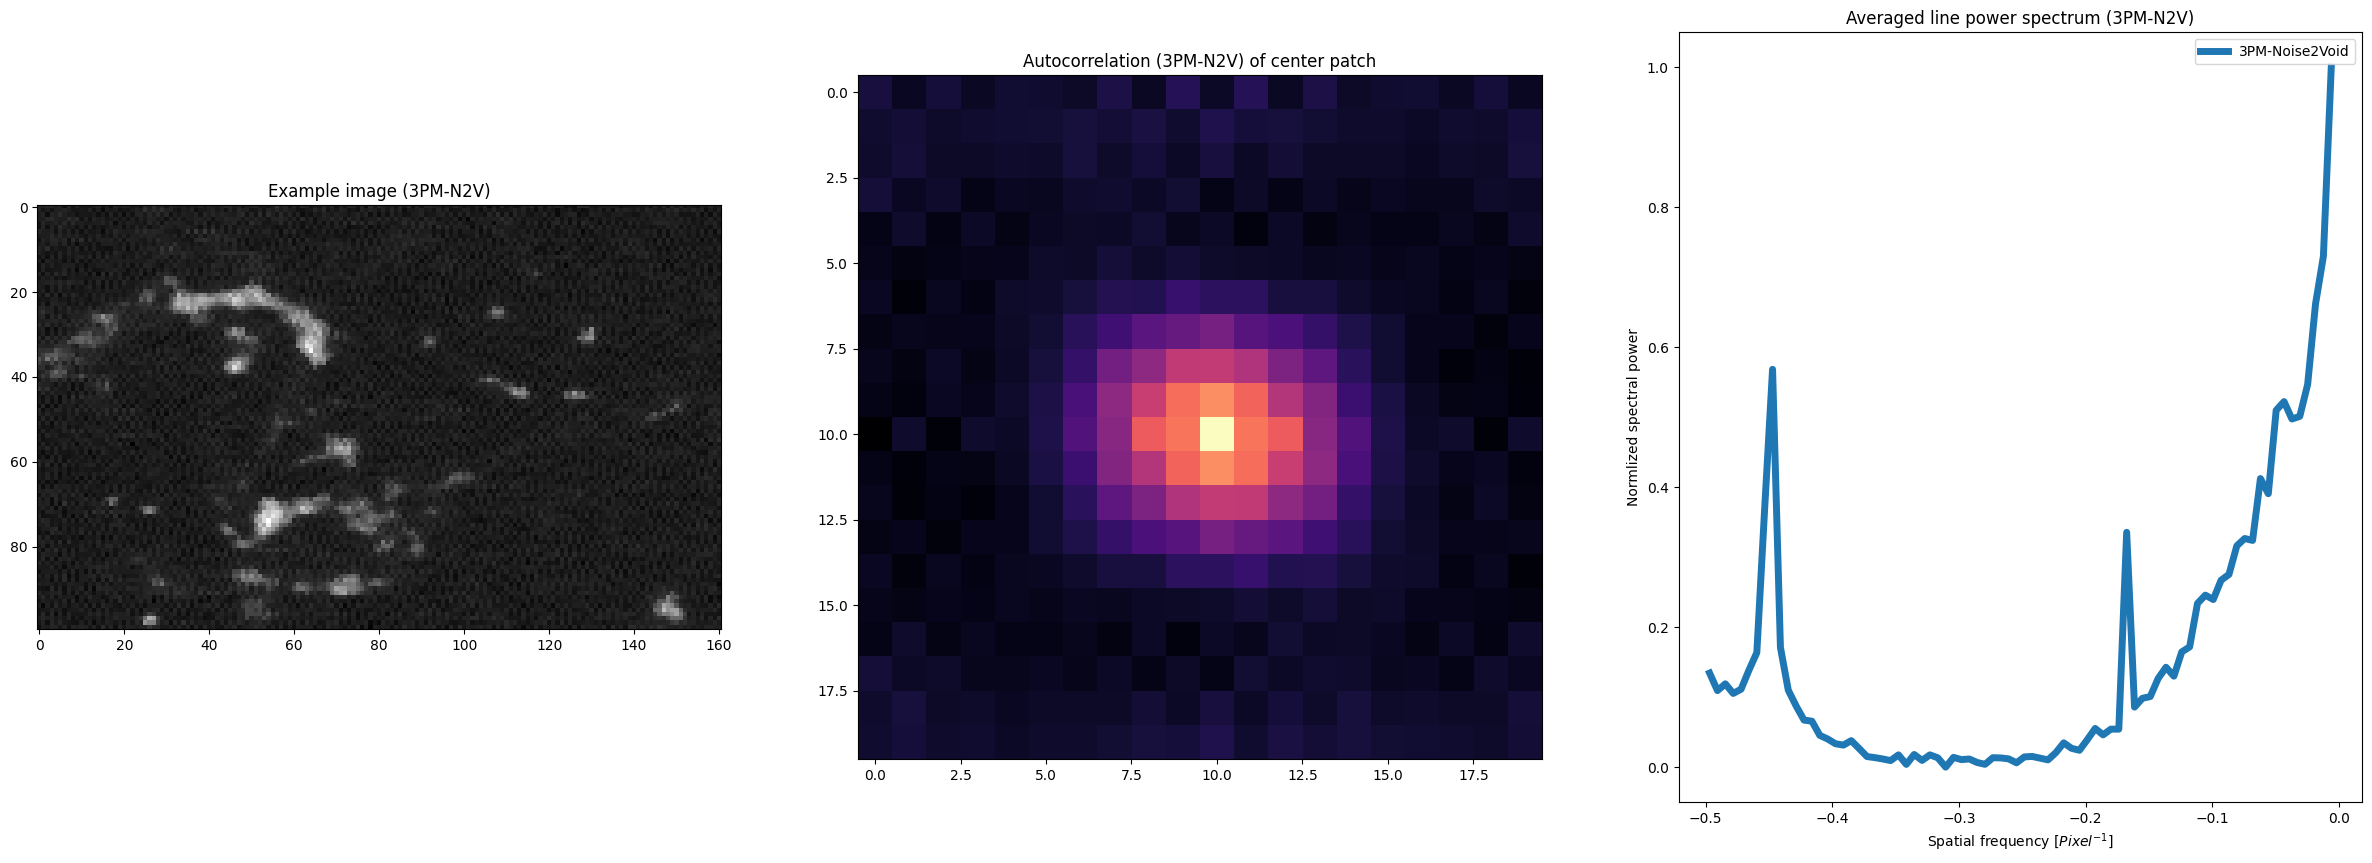

In [7]:
plt.figure(figsize=(30, 10))

plt.subplot(131)
plt.title("Example image (3PM-N2V)")
plt.imshow(file_example_denoised, cmap="gray")


plt.subplot(132)
plt.title("Autocorrelation (3PM-N2V) of center patch")
plt.imshow(example_autocorrelation, cmap="magma")

plt.subplot(133)
plt.title("Averaged line power spectrum (3PM-N2V)")
plt.plot(freqs, example_line_spectrum, linewidth = 5, label="3PM-Noise2Void")
plt.ylabel("Normlized spectral power")
plt.xlabel(r"Spatial frequency [$Pixel^{-1}$]")
plt.legend()

plt.tight_layout
plt.show()

## Detect the main frequency of the periodic structured noise

### Main frequency of the periodic structured noise 
  
The main frequency needs to be detected for the PerStruc-Denoiser to work effectively. Therefore, the line-wise spectrum of an example image (see below) of the recording needs to be inspected. The main components of periodic structured noise should be in the middle between left side and center of the spectrum and is clearly visible as a peak.

### Frequencies of remaining high frequency structured noise

There are some recordings, which contain high frequencies structured noise. This is visible as a peak close to the center of the line spectrum (see below) and can be effectively removed with an additional gaussian ($\sigma_{mask} = 1\ pixel$).

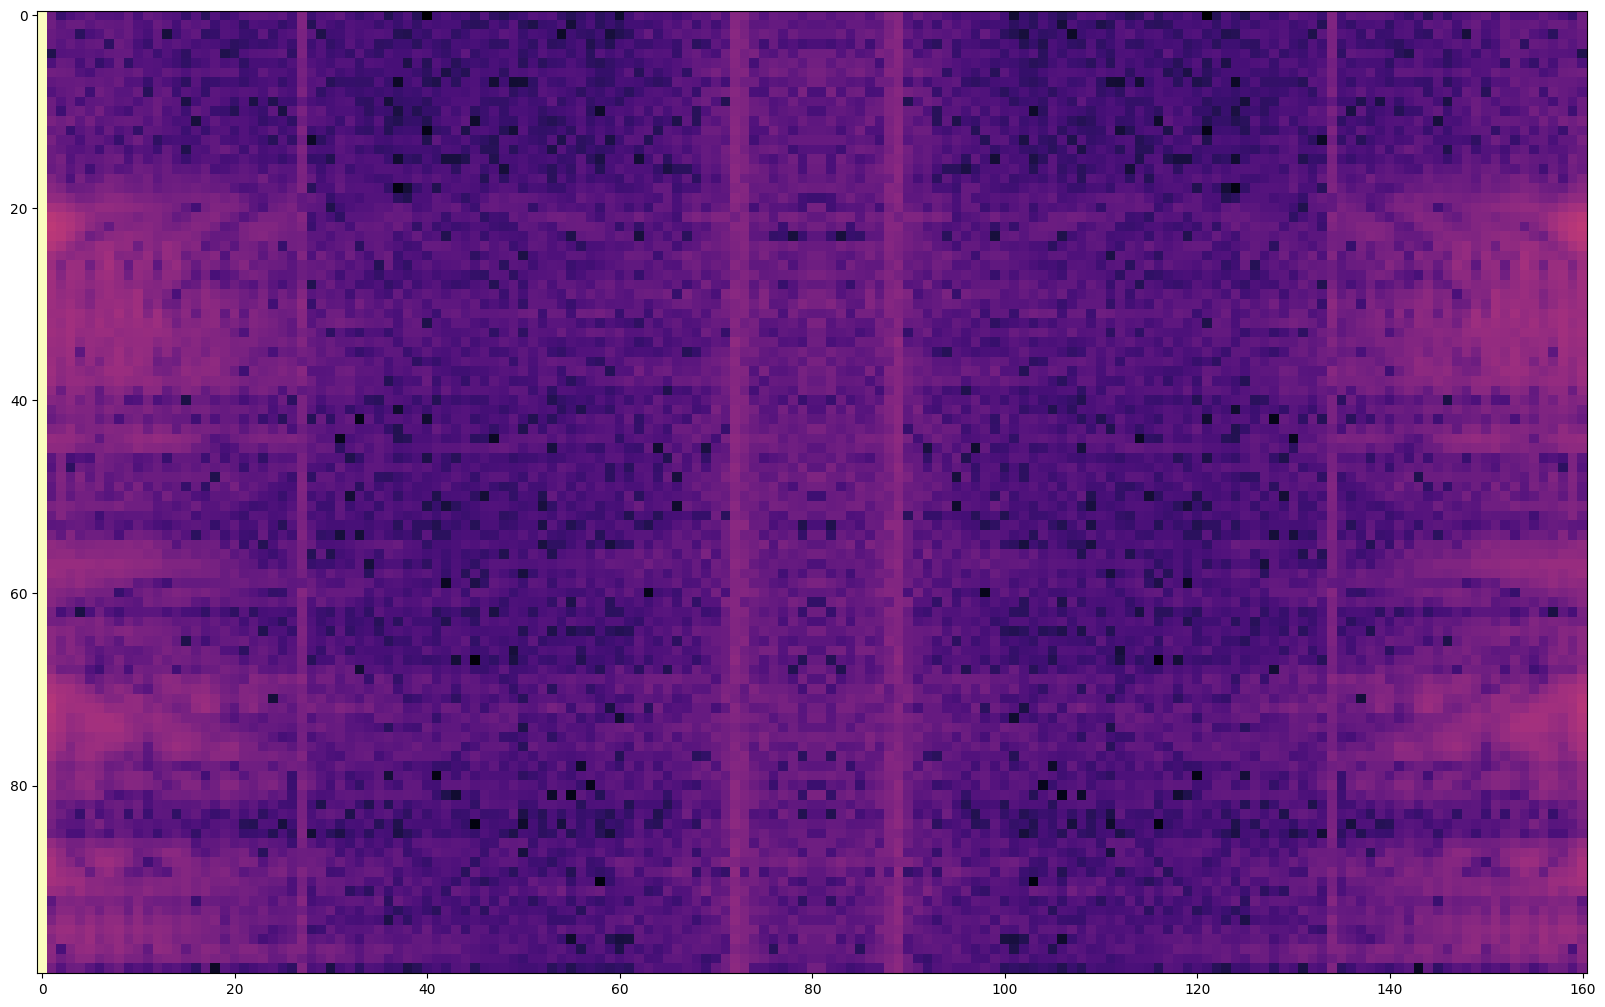

In [8]:
img_ft_line = utils.line_fft(file_example_denoised)

plt.figure(figsize=(20,15))
plt.imshow(np.log(np.abs(img_ft_line)), cmap='magma')
plt.rc('xtick', labelsize=18)
plt.show()

In [9]:
# Select a x-range to detected the exact x-position of the main frequency of the periodic structured noise #
x_range = [20, 40]
#**********************************************************************************************************#

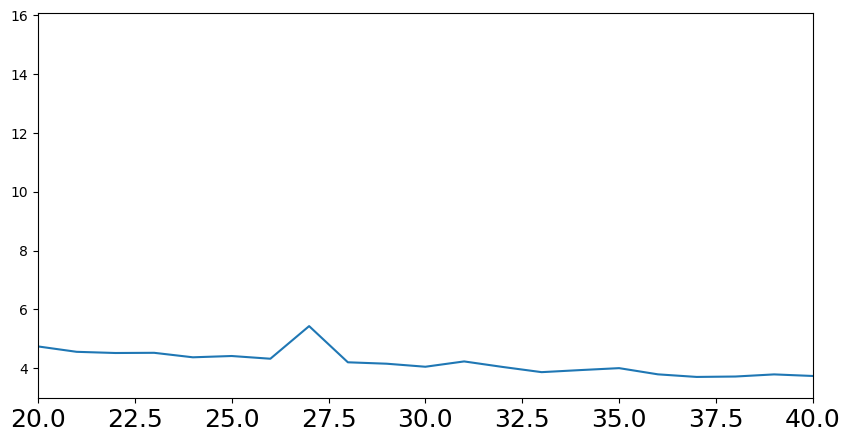

In [10]:
plt.figure(figsize=(10,5))
plt.plot(np.median(np.log(np.abs(img_ft_line)), axis=0))
plt.xlim([x_range[0], x_range[1]])
plt.rc('xtick', labelsize=18)
plt.show()

In [11]:
# Select the exact x-position of the main frequency of the periodic structured noise #
PEAK_POSITION = 27
#************************************************************************************#

## Apply PerStruc-Denoiser

In [12]:
file_denoised_pp = perstruc_denoiser(file_denoised, PEAK_POSITION)

100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 189.72it/s]


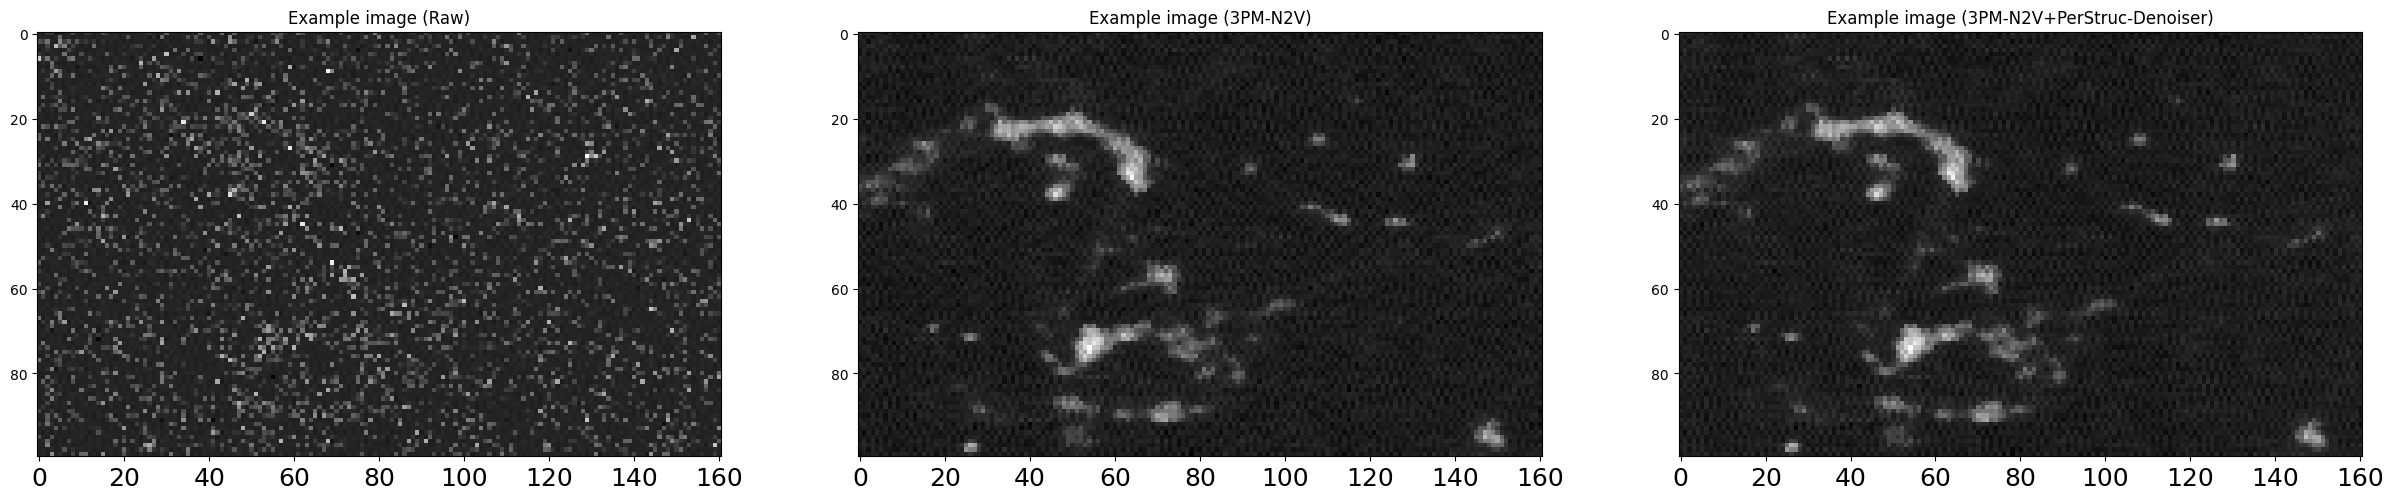

In [13]:
plt.figure(figsize=(30, 10))

plt.subplot(131)
plt.title("Example image (Raw)")
plt.imshow(file_raw[file_raw.shape[0]//2], cmap="gray")


plt.subplot(132)
plt.title("Example image (3PM-N2V)")
plt.imshow(file_example_denoised, cmap="gray")

plt.subplot(133)
plt.title("Example image (3PM-N2V+PerStruc-Denoiser)")
plt.imshow(file_denoised_pp[file_denoised_pp.shape[0]//2], cmap="gray")

plt.tight_layout
plt.show()

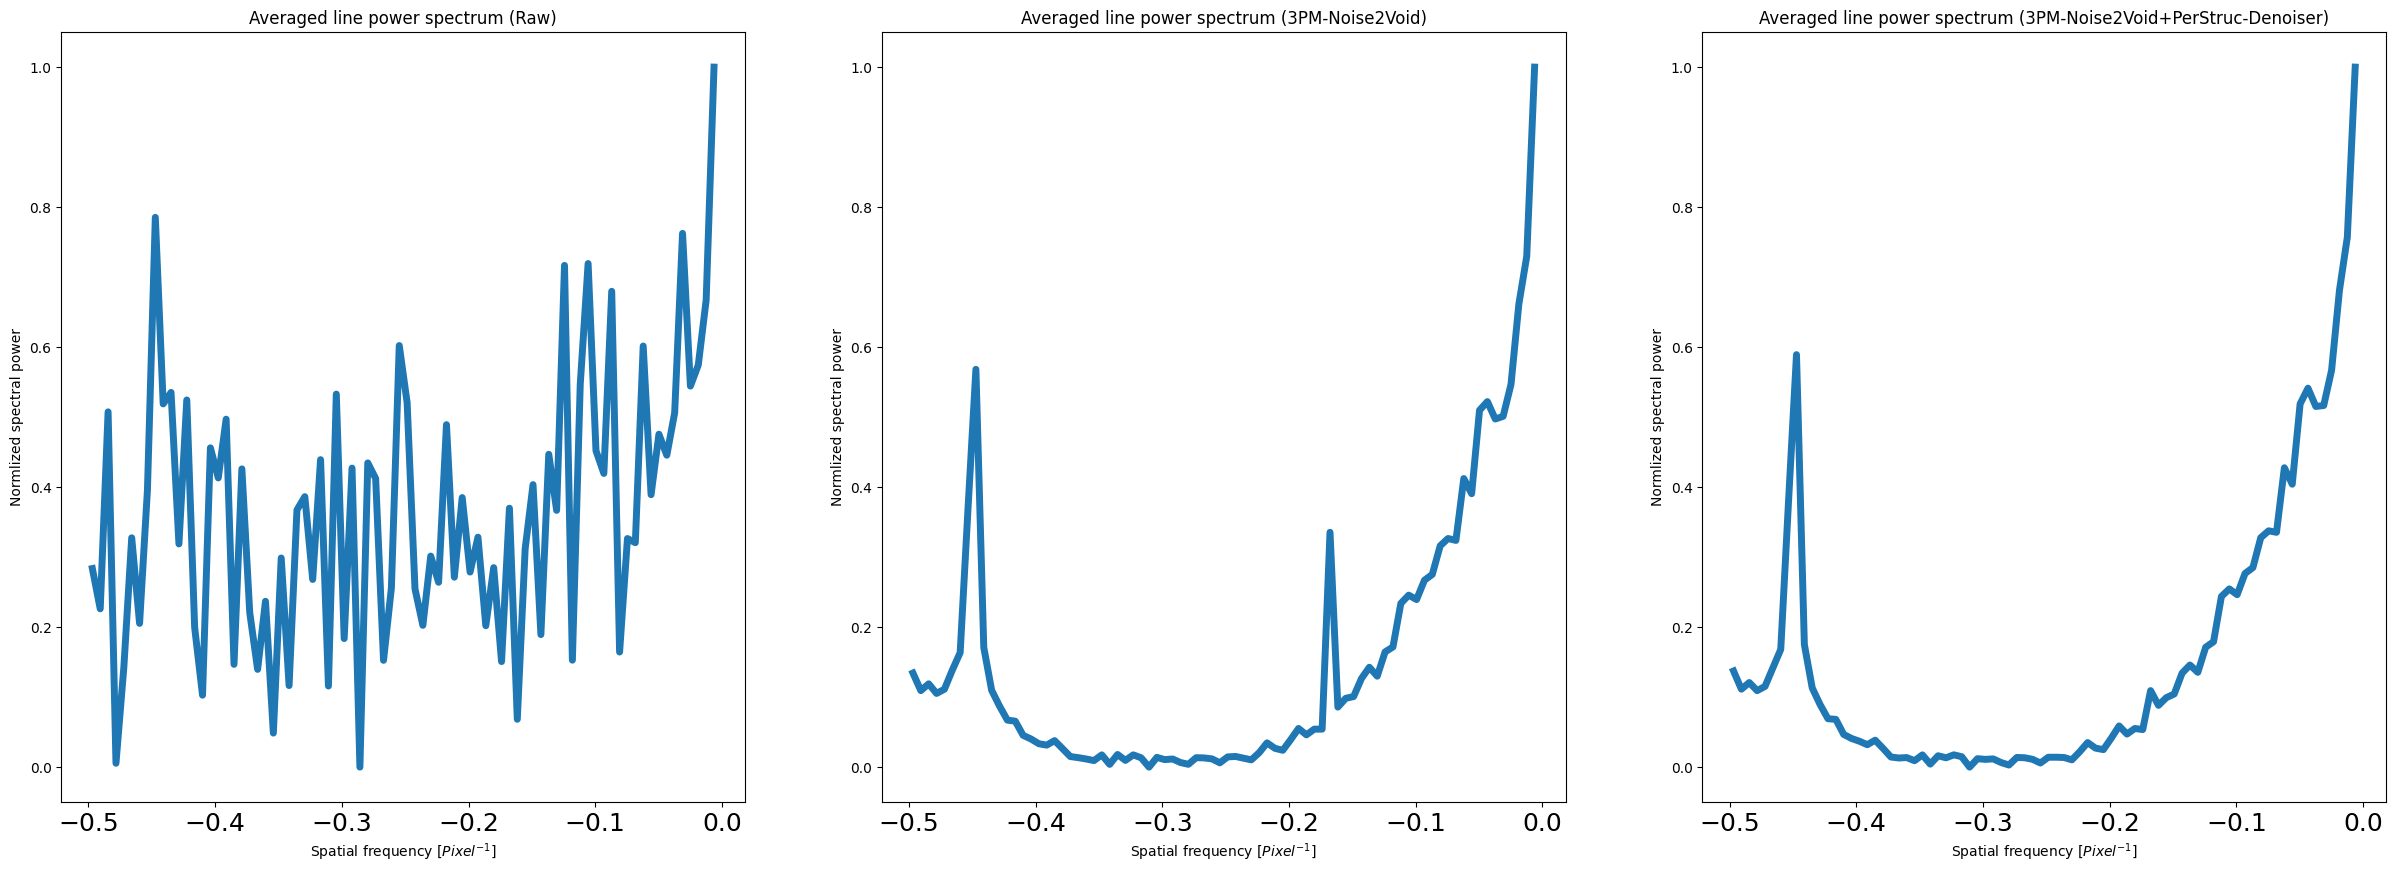

In [14]:
## Line power spectrum
# Raw
freqs, line_spectrum_raw = utils.line_power_spectrum(file_raw[file_raw.shape[0]//2])
# 3PM-N2V
_, line_spectrum_denoised = utils.line_power_spectrum(file_example_denoised)
# 3PM-N2V+PerStruc-Denoiser
_, line_spectrum_denoised_pp = utils.line_power_spectrum(file_denoised_pp[file_denoised_pp.shape[0]//2])

plt.figure(figsize=(30, 10))

plt.subplot(131)
plt.title("Averaged line power spectrum (Raw)")
plt.plot(freqs, line_spectrum_raw, linewidth = 5, label="Raw")
plt.ylabel("Normlized spectral power")
plt.xlabel(r"Spatial frequency [$Pixel^{-1}$]")

plt.subplot(132)
plt.title("Averaged line power spectrum (3PM-Noise2Void)")
plt.plot(freqs, line_spectrum_denoised, linewidth = 5, label="3PM-N2V")
plt.ylabel("Normlized spectral power")
plt.xlabel(r"Spatial frequency [$Pixel^{-1}$]")

plt.subplot(133)
plt.title("Averaged line power spectrum (3PM-Noise2Void+PerStruc-Denoiser)")
plt.plot(freqs, line_spectrum_denoised_pp, linewidth = 5, label="3PM-N2V+PerStruc-Denoiser")
plt.ylabel("Normlized spectral power")
plt.xlabel(r"Spatial frequency [$Pixel^{-1}$]")

plt.tight_layout
plt.show()

## Apply PerStruc-Denoiser + 1D-Gaussian-Filter

In [15]:
file_denoised_pp_1D = perstruc_denoiser(file_denoised, PEAK_POSITION, use_gaussian=True)

100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 173.01it/s]


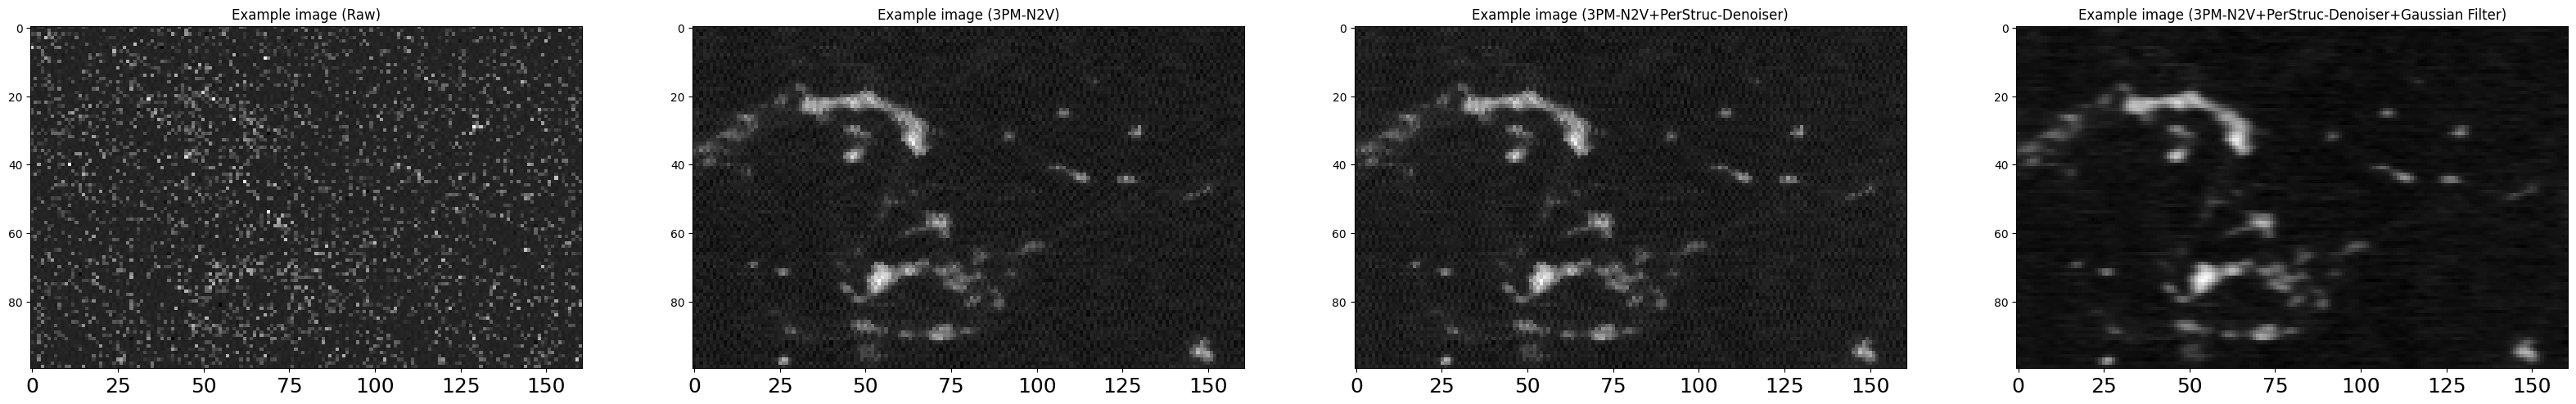

In [16]:
plt.figure(figsize=(40, 10))

plt.subplot(141)
plt.title("Example image (Raw)")
plt.imshow(file_raw[file_raw.shape[0]//2], cmap="gray")


plt.subplot(142)
plt.title("Example image (3PM-N2V)")
plt.imshow(file_example_denoised, cmap="gray")

plt.subplot(143)
plt.title("Example image (3PM-N2V+PerStruc-Denoiser)")
plt.imshow(file_denoised_pp[file_denoised_pp.shape[0]//2], cmap="gray")

plt.subplot(144)
plt.title("Example image (3PM-N2V+PerStruc-Denoiser+Gaussian Filter)")
plt.imshow(file_denoised_pp_1D[file_denoised_pp_1D.shape[0]//2], cmap="gray")
#plt.imshow(test[test.shape[0]//2], cmap="gray")

plt.tight_layout
plt.show()

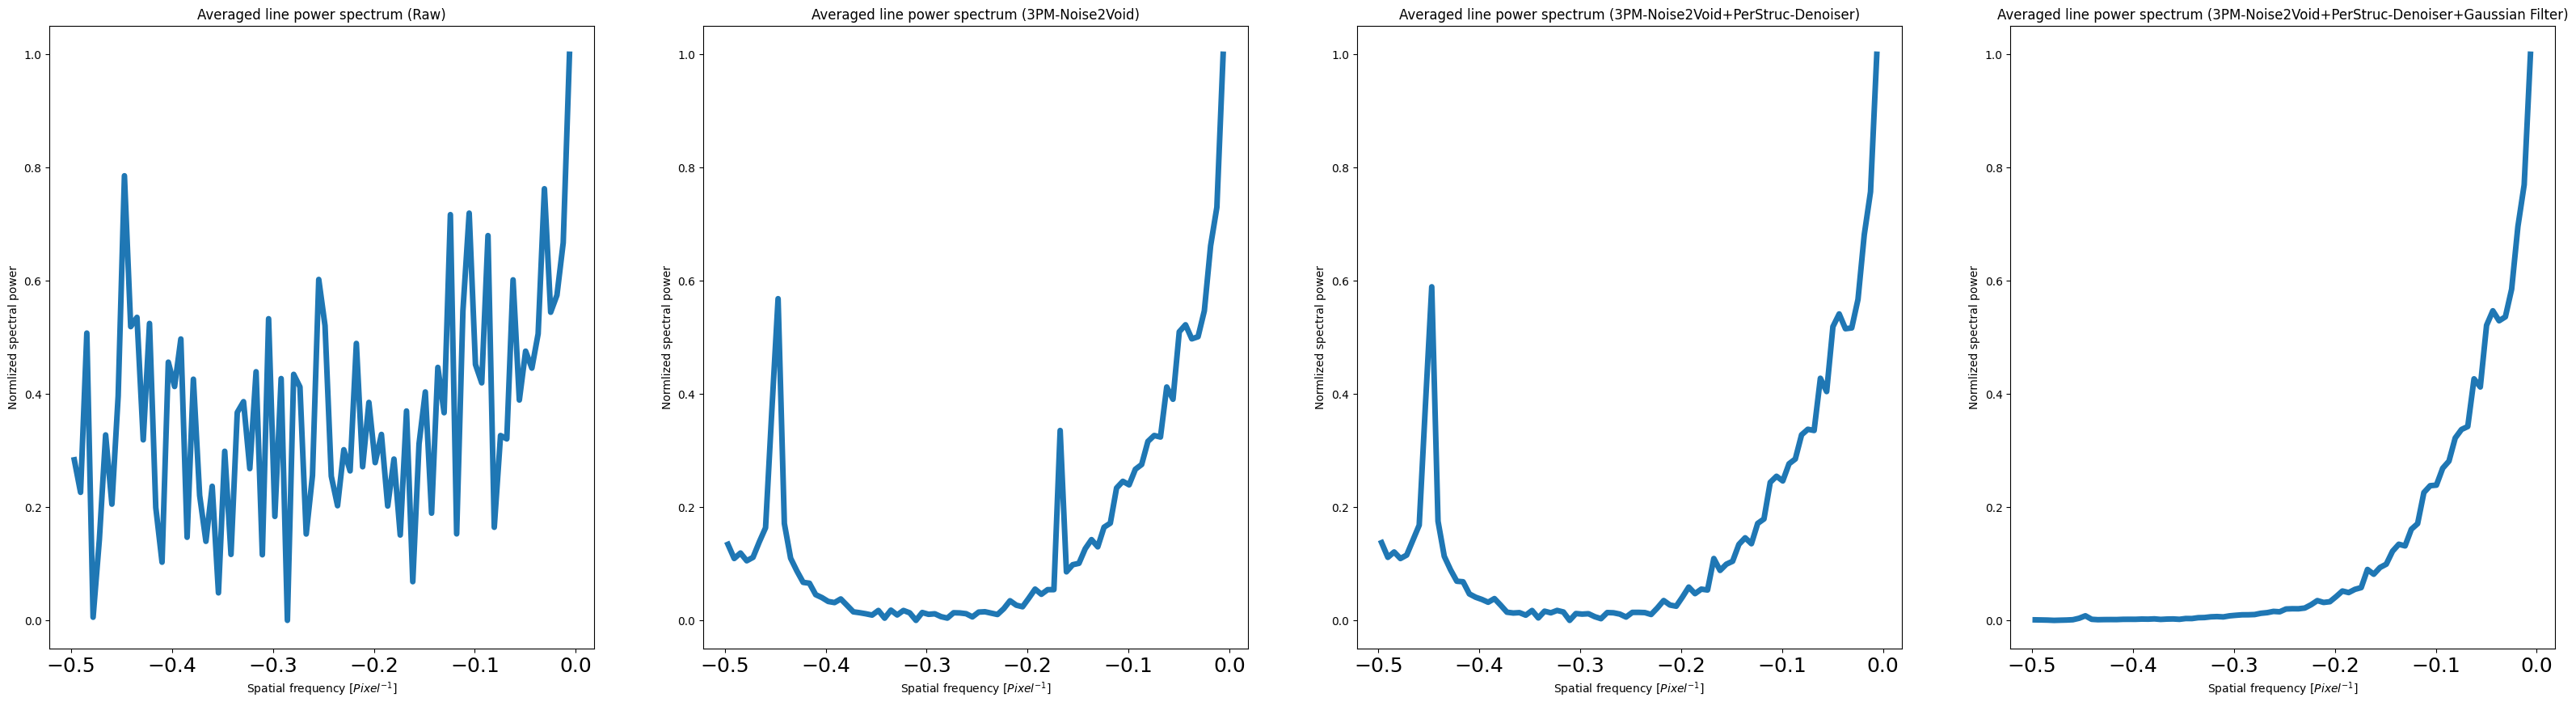

In [17]:
## Line power spectrum
# 3PM-N2V+PerStruc-Denoiser+Gaussian Filter
_, line_spectrum_denoised_pp_1D = utils.line_power_spectrum(file_denoised_pp_1D[file_denoised_pp_1D.shape[0]//2])

plt.figure(figsize=(40, 10))

plt.subplot(141)
plt.title("Averaged line power spectrum (Raw)")
plt.plot(freqs, line_spectrum_raw, linewidth = 5, label="Raw")
plt.ylabel("Normlized spectral power")
plt.xlabel(r"Spatial frequency [$Pixel^{-1}$]")

plt.subplot(142)
plt.title("Averaged line power spectrum (3PM-Noise2Void)")
plt.plot(freqs, line_spectrum_denoised, linewidth = 5, label="3PM-N2V")
plt.ylabel("Normlized spectral power")
plt.xlabel(r"Spatial frequency [$Pixel^{-1}$]")

plt.subplot(143)
plt.title("Averaged line power spectrum (3PM-Noise2Void+PerStruc-Denoiser)")
plt.plot(freqs, line_spectrum_denoised_pp, linewidth = 5, label="3PM-N2V+PerStruc-Denoiser")
plt.ylabel("Normlized spectral power")
plt.xlabel(r"Spatial frequency [$Pixel^{-1}$]")

plt.subplot(144)
plt.title("Averaged line power spectrum (3PM-Noise2Void+PerStruc-Denoiser+Gaussian Filter)")
plt.plot(freqs, line_spectrum_denoised_pp_1D, linewidth = 5, label="3PM-N2V+PerStruc-Denoiser+Gaussian Filter")
plt.ylabel("Normlized spectral power")
plt.xlabel(r"Spatial frequency [$Pixel^{-1}$]")

plt.tight_layout
plt.show()

## Store the PerStruc-Denoiser results

In [18]:
store_name_raw = os.path.join(path_results, filenames_raw[0].split(os.sep)[-1])
tifffile.imwrite(store_name_raw, file_raw)

In [19]:
store_name_denoised = os.path.join(path_results, filenames_denoised[0].split(os.sep)[-1])
tifffile.imwrite(store_name_denoised, file_denoised)

In [20]:
store_name_denoised_pp = os.path.join(path_results, filenames_denoised[0].split(os.sep)[-1][:-4] + '-PP.tif')
tifffile.imwrite(store_name_denoised_pp, file_denoised_pp)

In [21]:
store_name_denoised_pp_1D = os.path.join(path_results, filenames_denoised[0].split(os.sep)[-1][:-4] + '-PP-1D.tif')
tifffile.imwrite(store_name_denoised_pp_1D, file_denoised_pp_1D)